In [31]:
from __future__ import division
import numpy as np
import pylab as plt
import scipy.optimize as op
from scipy.integrate import odeint
from scipy.integrate import nquad
%matplotlib inline

In [39]:
# Distance in cm
# Density in GeV/cm^3
# kpc in cm 3,086e+21
kpc_to_cm=3.086e+21


# Spheroidal dwarf galaxies data
Dsphd_data = np.loadtxt("data_dwarf_galaxies.txt", usecols=(1,3,5,6,7,8))

In [40]:


def DM_density_NFW(r, rho_0, r_s, square=False):
    rho = rho_0 / ((r / r_s) * (1 + (r / r_s))**2 )
    if (square!=True):
        return rho
    else:
        return rho**2
    
def DM_density_BURK(r, rho_0, r_s, square=False):
    rho =  rho_0 / ((1 + r / r_s) * (1 + (r / r_s )**2))
    if (square!=True):
        return rho
    else:
        return rho**2
    
def DM_density_EIN(r, rho_0, r_s, a, square=False):
    rho = rho_0 * np.exp(-(2 / a) * ((r/r_s)**a - 1))
    if (square!=True):
        return rho
    else:
        return rho**2

def DM_density_GNFW(r, rho_0, r_s, gamma, square=False):
    rho = rho_0/((r/r_s)**gamma*(1+(r/r_s))**(3-gamma))
    if (square!=True):
        return rho
    else:
        return rho**2
    
    
# General DM density function
def DM_density(TYPE, r, rho_0, r_s, gamma=1, a=1, square=False):
    if ((TYPE=="NFW") or (TYPE=="nfw")):
        return DM_density_NFW(r, rho_0, r_s, square)
    elif ((TYPE=="Burk") or (TYPE=="Burkert") or (TYPE=="BURK")):
        return DM_density_BURK(r, rho_0, r_s, square)
    elif ((TYPE=="Ein") or (TYPE=="EIN") or (TYPE=="Einasto")):
        return DM_density_EIN(r, rho_0, r_s, a, square)
    elif ((TYPE=="GNFW") or (TYPE=="gnfw")):
        return DM_density_GNFW(r, rho_0, r_s, gamma, square)   
    else:
        print("Error: \tdensity profile TYPE was not recognized. Returned -1.")
        print("\tPlease specify either of the following profile TYPEs:")
        print("\t\t-\"NFW\" for Navarro-Frenk-White profile")
        print("\t\t-\"Burk\" for Burkert profile")
        print("\t\t-\"Ein\" for Einasto profile")
        print("\t\t-\"GNFW\" for generalized Navarro-Frenk-White profile")
        return -1
        
# Allows for computation of the dark matter density along the line of 
# sight. Parameters:
#     - l: the line of sight distance into the dark matter halo
#     - mu: the cosine of the viewing angle w.r.t. the galactic center
def DM_density_LOS(l, mu, d=8.5*kpc_to_cm, rho_0=0.471, r_s = 16*kpc_to_cm,
                   gamma=1, a=1, square=True, Type="NFW"):
    r = np.sqrt(l**2 + d**2 - 2*l*d*mu)
    return DM_density(Type, r, rho_0, r_s, gamma, a, square)      

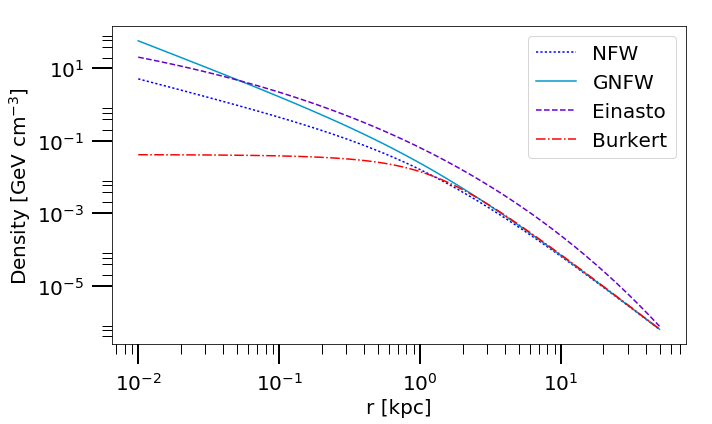

In [41]:
rho_0 = 0.471 # GeV/cm^3
r_s = 16*kpc_to_cm # cm
d = 8.5 * kpc_to_cm # cm

#  A range of input radii and plot parameters
r=np.logspace(np.log10(0.01*kpc_to_cm), np.log10(50*kpc_to_cm), 50)
a_lst = [1,1,0.2,1]
gamma_lst = [1, 1.5, 1, 1]
typelst = ["NFW", "GNFW", "Einasto", "Burkert"]
colorlst = ["b","#0099cc", "#6600cc", 'r']
linestylelst = [":", "-", "--", "-."]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for i in range(4):
    density = DM_density(typelst[i], r, rho_0, r_s, gamma_lst[i], a_lst[i])
    ax.plot(r/kpc_to_cm, density, color=colorlst[i], 
            linestyle=linestylelst[i], label=typelst[i])
ax.set_xlabel(r"r [kpc]", fontsize=20)
ax.set_ylabel(r"Density [GeV $\mathrm{cm}^{-3}}$]", fontsize=20)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_title("Compton scattered spectrum $E_{photon,in}=$"+str(e_in))
ax.tick_params('both', labelsize=20, length=20, width=2, which='major', pad=8)
ax.tick_params('both', labelsize=20, length=10, width=1, which='minor',pad=8)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

In [42]:
i=1
print(Dsphd_data[i-1,1])

250.0


Draco


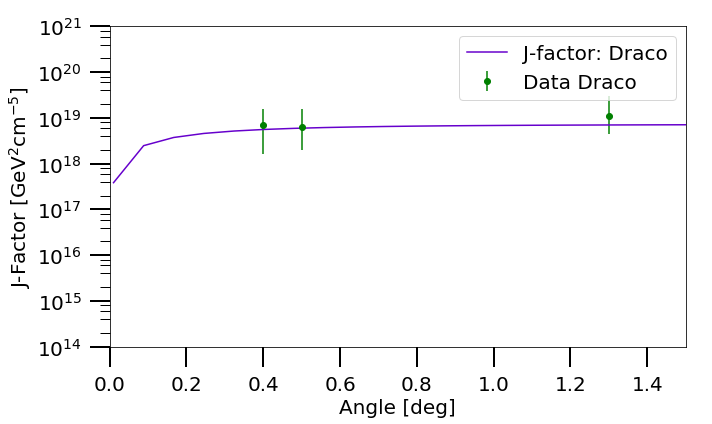

In [71]:
#objects=["Milky Way", "Carina", "Draco", "LeoII"]

def plot_dwarf_galaxies(d_factor, objects, profile_type, max_angle, nof_evals):
    # Plot parameters
    colorlst = ["b", "#0099cc", "#6600cc", 'r']

    # Initialize plot 
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_yscale("log")
    
    # Compute the J-factors
    angle = np.linspace(0.01, max_angle, nof_evals) # deg
    D_factors, J_factors = np.zeros([2, 5, nof_evals])

    for obj in objects:
        print(obj)
        if obj=="Milky Way":
            i=0
            # Milky Way parameters
            rho_0 = 0.471 # GeV/cm^3
            r_s = 16*kpc_to_cm # cm
            d = 8.5 * kpc_to_cm # cm
        elif obj=="Carina":
            i=1
            r_s = 5*Dsphd_data[i-1,1] * 1e-3 * kpc_to_cm
            rho_0=4.5e-2*(5*Dsphd_data[i-1,1] * 1e-3)**(-2/3)*36.97
            d = Dsphd_data[i-1,0] * kpc_to_cm
            carina_angle=[1.26, 0.15, 0.5]
            carina_j=np.array([17.92, 17.87, 18.1])
            carina_j_error=np.array([0.19, 0.1, 0.23])
            ylower = 10**(carina_j - carina_j_error)
            yupper= 10**(carina_j + carina_j_error)
            
            ax.errorbar(carina_angle, 10**carina_j, yerr=[ylower, yupper], c="k", label="Data Carina", fmt="o")
        elif obj=="Draco":
            i=2
            r_s = 5*Dsphd_data[i-1,1] * 1e-3 * kpc_to_cm
            rho_0=4.5e-2*(5*Dsphd_data[i-1,1] * 1e-3)**(-2/3)*36.97
            d = Dsphd_data[i-1,0] * kpc_to_cm
            draco_angle=[1.30, 0.40, 0.5]
            
            draco_j=np.array([19.05, 18.84, 18.8])
            draco_j_error=np.array([0.22, 0.12, 0.16])
            ylower = 10**(draco_j - draco_j_error)
            yupper= 10**(draco_j + draco_j_error)

            ax.errorbar(draco_angle, 10**draco_j, yerr=[ylower, yupper], c="g", label="Data Draco", fmt="o")
        elif obj=="LeoII":
            i=3
            r_s = 5*Dsphd_data[i-1,1] * 1e-3 * kpc_to_cm
            rho_0=4.5e-2*(5*Dsphd_data[i-1,1] * 1e-3)**(-2/3)*36.97
            d = Dsphd_data[i-1,0] * kpc_to_cm
            leoII_angle=[0.23, 0.04, 0.5]
            leoII_j=np.array([17.97, 17.97, 17.6])
            leoII_j_error=np.array([0.2, 0.2, 0.18])
            ylower = 10**(leoII_j - leoII_j_error)
            yupper= 10**(leoII_j + leoII_j_error)
            
            ax.errorbar(leoII_angle, 10**leoII_j, yerr=[ylower, yupper], c="r", label="Data Leo II", fmt="o")
        
        for j, theta in enumerate(angle):
            theta *= (np.pi / 180) # Conversion to rad
            if d_factor==True:
                D = nquad(DM_density_LOS, [[0,2*d],[np.cos(theta),1]],
                                args=(d, rho_0, r_s, 1, 1, False, profile_type), epsrel=1e-3, opts={"epsrel":1e-3})
                D_factors[i,j] = 2*np.pi * D[0]
            
            J = nquad(DM_density_LOS, [[0,2*d],[np.cos(theta),1]],
                            args=(d, rho_0, r_s, 1, 1, True, profile_type),  opts={"epsrel":1e-3})
            J_factors[i,j] = 2*np.pi * J[0]
        
        if d_factor==True:
            ax.plot(angle, D_factors[i], color=colorlst[i], linestyle="--", label="D-factor: "+ obj)

        ax.plot(angle, J_factors[i], color=colorlst[i], linestyle='-', label="J-factor: "+ obj)

    ax.set_xlabel("Angle [deg]", fontsize=20)
    ax.set_ylabel(r"J-Factor [$\mathrm{GeV}^2 \mathrm{cm}^{-5}$]", fontsize=20)
    
    ax.set_ylim([float(10**14), float(10**21)])
    ax.set_xlim([0,max_angle])
    #ax.set_title("Compton scattered spectrum $E_{photon,in}=$"+str(e_in))
    ax.tick_params('both', labelsize=20, length=20, width=2, which='major', pad=8)
    ax.tick_params('both', labelsize=20, length=10, width=1, which='minor',pad=8)
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.show()


plot_dwarf_galaxies(d_factor=False, objects=["Draco"], profile_type="NFW", max_angle=1.5, nof_evals=20)